In [1]:
pip install PyMieScatt

Note: you may need to restart the kernel to use updated packages.


In [10]:
import PyMieScatt as ps
import numpy as np
from PyMieScatt.Mie import Mie_ab
import matplotlib.pyplot as plt
from matplotlib.contour import QuadContourSet
from matplotlib.collections import LineCollection
from scipy.ndimage import zoom
from scipy.integrate import trapz
from shapely import geometry
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
from numpy import linalg as npl
import scipy.linalg as spl
import time

### Distributions 
We define two types of distributions and we try to retrieve them by using this algorithm

In [11]:
def lognormal(d,dmoy,sigma):
  d_mean = (1/len(d))*sum(d)
  q = (1/(np.sqrt(2*np.pi)*d*sigma))*np.exp((-1*(np.log(d)-np.log(dmoy))**2)/(2*sigma**2))
  return q

def normal(a, sigma):
  #a*=1e3
  a0=(a[0]+a[-1])/2
  return (1/np.sqrt(2*np.pi*sigma))*np.exp(-1*(a-a0)**2/(sigma**2))

### Function to calculate an SVD of a matrix 

### Calcul of intensity $K(\lambda, a)$

$K(\lambda, a) =\frac{i_{1}+i_{2}}{8 \pi^{2} r^{2}} \lambda^{2}$



In [12]:
def inten(w, n, d, theta,r=1e-6):  #r=1m ? 
    #d*=1e3
    S1,S2=ps.MieS1S2(n,np.pi*d/w,np.cos(theta))
    SL=np.abs(S1)**2
    SR=np.abs(S2)**2
    return w**2*(SL**2+SR**2)/(8*(np.pi*r)**2)

### Discretisation of the L and A operators 

$L [f(a)]=\int_{0}^{\infty} K(\lambda, a) f(a) \mathrm{d} a$ 

$A=L^*L$

The objective is to compute the eigen values $\alpha_k$ and eigenvectors $u_k$ of the matrix $A$.

For this we calculate the operator L, represented by a matrix composed by elements $\left(L(\lambda_j,a_i)\right)_{1\leq j \leq M, 1\leq i \leq N}$ 


In [5]:
#Premier code de l'opérateur
def L_op(d, x,w, sigma,n,theta):
  q=lognormal(d,x, sigma)
  N=len(d)
  M=len(w)
  #moy=(d[-1]+d[0])/2
  L=np.zeros((N,M))
  for i in range(N):
    for j in range(M):
      L[i,j]=inten(w[j],n,d[i],theta)*q[i]
  return L


#Calcul of A
def Oper(L):
    return L.T@L
  

### Finding the f distribution with regularization term $\mu$
$f_{\mu}\left(a_{i}\right)=\sum_{k=1}^{N}\left[\alpha_{k}\left(\alpha_{k}^{2}+\mu\right)^{-1} \sum_{j=1}^{M} w_{k} g\left(\lambda_{j}\right) v_{k}\left(\lambda_{j}\right)\right] u_{k}\left(a_{i}\right)$

In [ ]:
def vector_g(w,n,x,theta):
  g=np.zeros(len(w))
  for j in range(len(w)):
   g[j]=inten(w[j], n, x, theta)
  return g

In [ ]:
def f_mu(v, alp, u, d, w, sigma, theta, n,mu,dQ,i):
  N=len(d)
  M=len(w)
  moy=sum(d)/len(d)
  fmu=[]
  g=vector_g(w,n,dQ[i],theta)
    #calcul of the sum
  for k in range(N):
    pr=u[k][i]*alp[k]/(alp[k]**(2)+mu)
    fint=0
    for j in range(M):
      fint+=g[j]*v[k][j]  
      fmu.append(fint*pr)
  return sum(fmu)

In [ ]:
#plot of the real solution 
def retrieve_distrib(d, x, w, sigma, n, theta, mu):
  distrib=np.zeros(len(d))
  #moy=[] #to calculate an average on a delta theta
  #for q in range(len(theta)): #calcul for different theta 
  Lt=L_op(d, x, w, sigma,n,theta)
        
  u,S,vg=npl.svd(Lt) #calcul of the SVD to call f_mu 
  Qi=np.zeros(len(d))
  log=lognormal(d,x, sigma)
  for j in range(len(d)):
    bruit=np.random.normal(0,0.1e-4)
    while log[j]+bruit<0:
      bruit=np.random.normal(0,0.05e-4)
    Qi[j]=log[j]+bruit
  #print(npl.norm(Qi-log))
  #Qi*=1e5
  
  for i in range(len(d)): #calcul of the solution according to several diameters 
    distrib[i]=np.abs(f_mu(vg, S, u,d, w, sigma, theta,n, mu, Qi, i))
    #max(f_mu(vg, S, u,d, w, sigma, mu, n, k,theta|q],i),0)
      #moy.append(distrib) #distribution list for a delta theta

  #MOY=np.array(moy)
  #MOY=np.mean(MOY, axis=0) #average on all the distributions
  
  n_exp=np.argmax(distrib)
  n_th=np.argmax(Qi)
#print(d[n_exp], d[n_th])
  #error=np.abs(d[n_exp]-d[n_th])
  error=npl.norm((d[n_exp]-d[n_th])/d[n_th])*100
  
  return distrib, error, Qi#MOY


### Parameters

In [ ]:
n=1.33
N=100
M=100
x_liste=np.linspace(0.1e3,30e3,N)
x=20e3
wl=np.linspace(400,800,M)
sigma=0.3
theta=4
#Norm=lognormal(x_liste, sigma)
#delta=len(theta)
mu=np.exp(-45)
#print(lognormal(x_liste,sigma))


### Plot of the average of the results for an average on $\Delta \theta$ 




temps 25.327918767929077


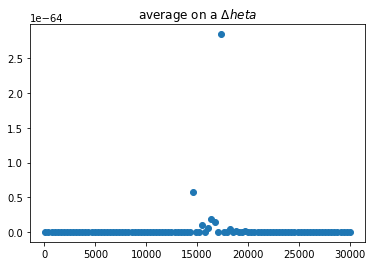

erreur 0.0


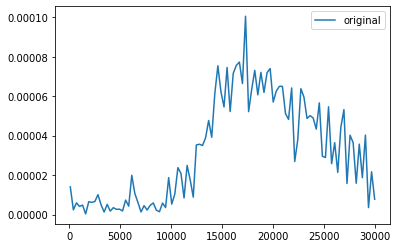

In [ ]:
t1=time.time()
distrib_exp,error_rel, norm=retrieve_distrib(x_liste, x, wl, sigma, n, theta,mu)
t2=time.time()
print("temps",t2-t1)
plt.scatter(x_liste,distrib_exp)
plt.title("average on a $\Delta \theta$")
plt.show()
plt.plot(x_liste,norm,label="original")
plt.legend()
print("erreur", error_rel)

In [ ]:
distrib_exp2,error_rel2,norm2=retrieve_distrib(x_liste, x, wl, sigma, n, theta,mu)
print("diff distrib",npl.norm(distrib_exp2-distrib_exp))
print("diff erreur",np.abs(error_rel-error_rel2))


diff distrib 2.7640700411407407e-64
diff erreur 0.0


## Code validation

In [ ]:
import pandas as pd
from google.colab import files

In [27]:
def display_heatmap(im):
    fig, ax = plt.subplots(figsize=(7,6))
    img = ax.imshow(im,cmap = 'cividis',extent=[-1,1,-1,1])
    x_label_list = [1.33,1.43,1.53,1.63,1.73,1.8]
    y_label_list = [30000,24100,18100,12100,6100,100]
    ax.set_xticks([-1,-0.6,-0.2,0.2,0.6,1])
    ax.set_yticks([-1,-0.6,-0.2,0.2,0.6,1])
    ax.set_xticklabels(x_label_list)
    ax.set_yticklabels(y_label_list)
    ax.set_xlabel("Refractive index $m$")
    ax.set_ylabel("Diameters $x$ (nm)")
    fig.colorbar(img)
    plt.show()

In [ ]:
wavelength = 532
N_dis=64
diameter = np.linspace(0.1e3,30e3,N_dis)
index = np.linspace(1.33,1.8,N_dis)

angular_domain1 = [0.9,6.7]
angular_domain2 = [10,90]
angular_domain3 = [175,180]

spectral_domain = [400,800]

theta_list = [4,20,178,180]

In [ ]:
domain = angular_domain1 
diam = diameter[0]               #replace by the index of the collab 
theta0=theta_list[1]
relative_error = []
matrix = np.zeros((N_dis,N_dis))
#solution = np.zeros((N_dis,4))
sigma = 0.3
mu=np.exp(-45)
wl=np.linspace(400,800,M)

for i in range(len(diameter)):
    for j in range(len(index)): 
        print(i,j)
        #range_diameter = np.linspace(diameter[i]-diam+1, diameter[i]+diam+1, 100)
        x_exp,x_err_relative, norm=retrieve_distrib(diameter, diameter[i], wl, sigma, index[j], theta0,mu)
        matrix[i,j] = x_err_relative
        #solution[i,j] = point[0]


#loading the matrix with the index of the collab
matrix = pd.DataFrame(matrix)
#solution = pd.DataFrame(solution)
matrix.to_csv('matrix_SVD0_spec2.csv')
#solution.to_csv('solution_SVD0_spec.csv')
files.download('matrix_SVD0_spec2.csv')
#files.download('solution_SVD0_spec.csv')


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15


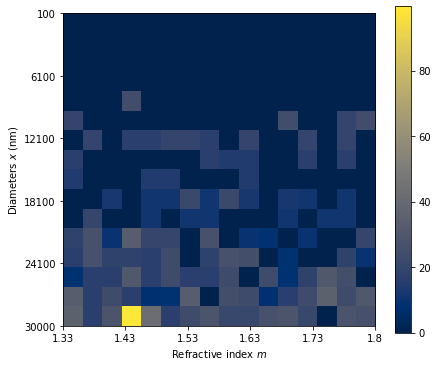

In [ ]:
display_heatmap(matrix)

## Angular method

In [13]:
def L_op_theta(d,x, w, sigma,n,theta):
  q=lognormal(d,x,sigma)
  N=len(d)
  M=len(theta)
  #moy=(d[-1]+d[0])/2
  L=np.zeros((N,M))
  for i in range(N):
    for j in range(M):
      L[i,j]=inten(w,n,d[i],theta[j])*q[i]
  return L

In [14]:
def vector_g_theta(w,n,x,minA,maxA,res):
  g=ps.ScatteringFunction(n,w,x,minAngle=minA,maxAngle=maxA,angularResolution=res)
  return g

In [15]:
def f_mu_theta(v, alp, u, d, wfix, sigma, theta_list, n,mu,dQ,i):
  
  N=len(d)
  M=len(theta_list)
  #moy=sum(d)/len(d)
  #log=lognormal(d,x, sigma)
 
  fmu=[]
  g=vector_g_theta(wfix,n,dQ[i], theta_list[0],theta_list[-1],(np.abs(theta_list[0]-theta_list[-1]))/len(theta_list))[3]
    #calcul of the sum
  for k in range(N):
    pr=u[k][i]*alp[k]/(alp[k]**(2)+mu)
    fint=0
    for j in range(M):
      fint+=g[j]*v[k][j]  
      fmu.append(fint*pr)
  return sum(fmu)

In [16]:
#plot of the real solution 
def retrieve_distrib_theta(d, x, w, sigma, n, theta, mu,):
    distrib=np.zeros(len(d))
    Lt=L_op_theta(d,x, w, sigma,n,theta)
        #Lt=Lt/(npl.norm(Lt)**2) #normalization ??

    u,S,vg=npl.svd(Lt) #calcul of the SVD to call f_mu 
    #Qi=np.zeros(len(d))
    #log=lognormal(d,x, sigma)
    Qi=lognormal(d,x,sigma)
    # for j in range(len(d)):
    #   bruit=np.random.normal(0,0.1e-4)
    #   while log[j]+bruit<0:
    #     bruit=np.random.normal(0,0.05e-4)
    #   Qi[j]=log[j]+bruit

    for i in range(len(d)): #calcul of the solution according to several diameters 
      distrib[i]=np.abs(f_mu_theta(vg, S, u,d, w, sigma,  theta, n, mu,Qi,i))#max(f_mu(vg, S, u,d, w, sigma, mu, n, k,theta|q],i),0)

    n_exp=np.argmax(distrib)
    n_th=np.argmax(Qi)
#print(d[n_exp], d[n_th])
  #error=np.abs(d[n_exp]-d[n_th])
    error=npl.norm((d[n_exp]-d[n_th])/d[n_th])*100

    return distrib, error, Qi

### Parameters

In [42]:
n=1.33
N=100
M=100
x_liste=np.linspace(0.1e3,30e3,N)
wl=532
sigma=0.3
x=20e3
theta_list=np.linspace(0.9,6.7,M)
Norm=lognormal(x_liste, x_liste[30], sigma)
mu=np.exp(-45)
#g_test=vector_g_theta(wl[1],n,x_liste[10], theta_list[0],theta_list[-1],(np.abs(theta_list[0]-theta_list[-1]))/len(theta_list))
#print(g_test)

### Plot of the distriution (angular)

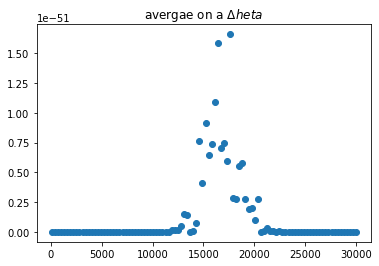

3.3150396363434713


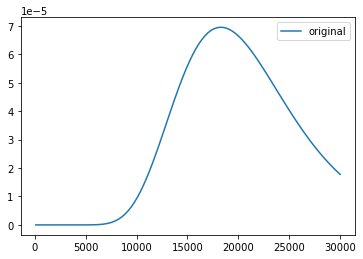

In [43]:
distrib_exp_theta,err,norm=retrieve_distrib_theta(x_liste,x, wl, sigma, n, theta_list, mu)

plt.scatter(x_liste,distrib_exp_theta)
plt.title("avergae on a $\Delta \theta$")
plt.show()
plt.plot(x_liste,norm,label="original")
plt.legend()
print(err)

In [44]:
plt.style.use(['science','notebook'])

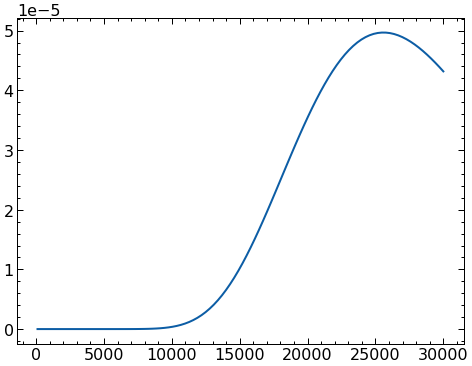

In [45]:
plt.plot(x_liste,lognormal(x_liste,28e3,sigma))

### Error on the retrieved diameter (angular)



In [18]:
n_exp_theta=np.argmax(distrib_exp_theta)
n_th=np.a
rgmax(Norm)
#print(d[n_exp], d[n_th])
error=npl.norm(x_liste[n_exp_theta]-x_liste[n_th])
error_relat=npl.norm((x_liste[n_exp_theta]-x_liste[n_th])/(x_liste[n_th]))*100
print("erreur", error)
print("relative error",error_relat)

NameError: name 'distrib_exp_theta' is not defined

In [23]:
N_dis=64
diameter = np.linspace(0.1e3,30e3,N_dis)
index = np.linspace(1.33,1.8,N_dis)

angular_domain1 = [0.9,6.7]
angular_domain2 = [10,90]
angular_domain3 = [175,180]

spectral_domain = [400,800]

theta_list = [4,20,178,180]

In [24]:
domain = np.linspace(angular_domain1[0],angular_domain1[1],N_dis)
#diam = diameter[0]               #replace by the index of the collab 
#theta0=theta_list[1]
#relative_error = []
matrix = np.zeros((N_dis,N_dis))
#solution = np.zeros((N_dis,4))
sigma = 0.3
mu=np.exp(-45)
wl=532

for i in range(len(diameter)):
    for j in range(len(index)): 
        print(i,j)
        #range_diameter = np.linspace(diameter[i]-diam+1, diameter[i]+diam+1, 100)
        x_exp,x_err_relative, norm=retrieve_distrib_theta(diameter, diameter[i], wl, sigma, index[j], domain,mu)
        matrix[i,j] = x_err_relative
        #solution[i,j] = point[0]





0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15


23 41
23 42
23 43
23 44
23 45
23 46
23 47
23 48
23 49
23 50
23 51
23 52
23 53
23 54
23 55
23 56
23 57
23 58
23 59
23 60
23 61
23 62
23 63
24 0
24 1
24 2
24 3
24 4
24 5
24 6
24 7
24 8
24 9
24 10
24 11
24 12
24 13
24 14
24 15
24 16
24 17
24 18
24 19
24 20
24 21
24 22
24 23
24 24
24 25
24 26
24 27
24 28
24 29
24 30
24 31
24 32
24 33
24 34
24 35
24 36
24 37
24 38
24 39
24 40
24 41
24 42
24 43
24 44
24 45
24 46
24 47
24 48
24 49
24 50
24 51
24 52
24 53
24 54
24 55
24 56
24 57
24 58
24 59
24 60
24 61
24 62
24 63
25 0
25 1
25 2
25 3
25 4
25 5
25 6
25 7
25 8
25 9
25 10
25 11
25 12
25 13
25 14
25 15
25 16
25 17
25 18
25 19
25 20
25 21
25 22
25 23
25 24
25 25
25 26
25 27
25 28
25 29
25 30
25 31
25 32
25 33
25 34
25 35
25 36
25 37
25 38
25 39
25 40
25 41
25 42
25 43
25 44
25 45
25 46
25 47
25 48
25 49
25 50
25 51
25 52
25 53
25 54
25 55
25 56
25 57
25 58
25 59
25 60
25 61
25 62
25 63
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7
26 8
26 9
26 10
26 11
26 12
26 13
26 14
26 15
26 16
26 17
26 18
26 19
26 2

45 36
45 37
45 38
45 39
45 40
45 41
45 42
45 43
45 44
45 45
45 46
45 47
45 48
45 49
45 50
45 51
45 52
45 53
45 54
45 55
45 56
45 57
45 58
45 59
45 60
45 61
45 62
45 63
46 0
46 1
46 2
46 3
46 4
46 5
46 6
46 7
46 8
46 9
46 10
46 11
46 12
46 13
46 14
46 15
46 16
46 17
46 18
46 19
46 20
46 21
46 22
46 23
46 24
46 25
46 26
46 27
46 28
46 29
46 30
46 31
46 32
46 33
46 34
46 35
46 36
46 37
46 38
46 39
46 40
46 41
46 42
46 43
46 44
46 45
46 46
46 47
46 48
46 49
46 50
46 51
46 52
46 53
46 54
46 55
46 56
46 57
46 58
46 59
46 60
46 61
46 62
46 63
47 0
47 1
47 2
47 3
47 4
47 5
47 6
47 7
47 8
47 9
47 10
47 11
47 12
47 13
47 14
47 15
47 16
47 17
47 18
47 19
47 20
47 21
47 22
47 23
47 24
47 25
47 26
47 27
47 28
47 29
47 30
47 31
47 32
47 33
47 34
47 35
47 36
47 37
47 38
47 39
47 40
47 41
47 42
47 43
47 44
47 45
47 46
47 47
47 48
47 49
47 50
47 51
47 52
47 53
47 54
47 55
47 56
47 57
47 58
47 59
47 60
47 61
47 62
47 63
48 0
48 1
48 2
48 3
48 4
48 5
48 6
48 7
48 8
48 9
48 10
48 11
48 12
48 13
48 14
48 1

In [25]:
np.save('SVD_ang1-2', matrix)

In [ ]:
#loading the matrix with the index of the collab
matrix = pd.DataFrame(matrix)
#solution = pd.DataFrame(solution)
matrix.to_csv('matrix_SVD0_ang1.csv')
#solution.to_csv('solution_SVD0_spec.csv')
files.download('matrix_SVD0_ang1.csv')
#files.download('solution_SVD0_spec.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

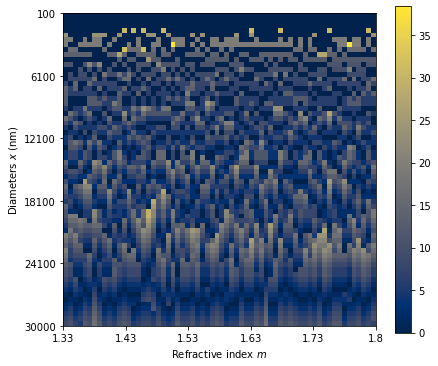

In [17]:
data2=np.load('SVD_ang1-2.npy')
display_heatmap(data)

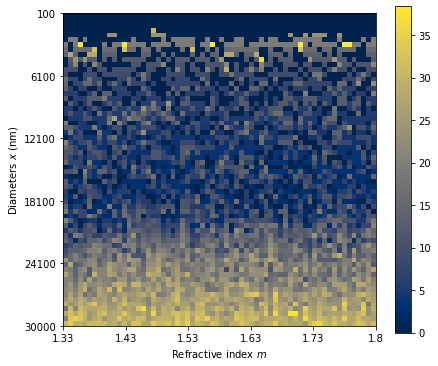

In [29]:
data2=np.load('SVD_ang1-2.npy')
display_heatmap(data2)

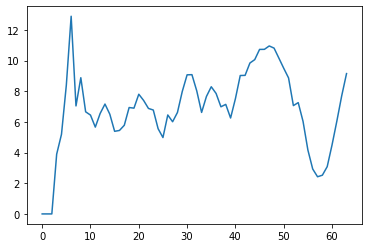

In [23]:
plt.plot(np.mean(data, axis=1))

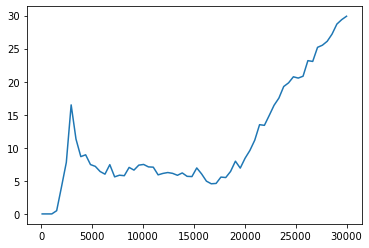

In [38]:
plt.plot(diameter,np.mean(data2,axis=1))

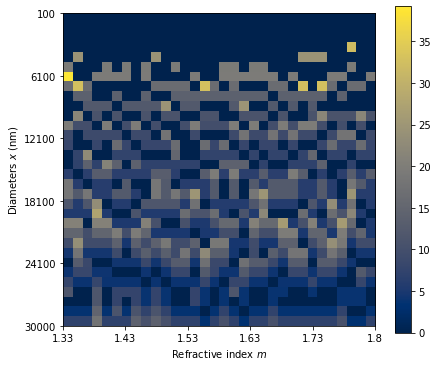

In [ ]:
#sans bruit
display_heatmap(matrix)

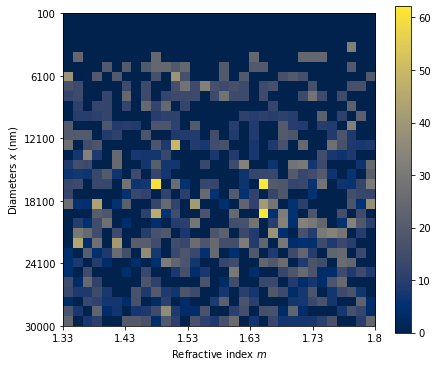

In [ ]:
#avec bruit
display_heatmap(matrix)

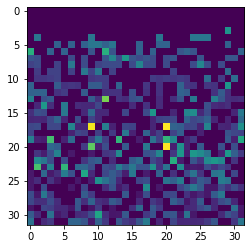

In [ ]:
plt.imshow(matrix)